In [2]:
from itertools import product
from math import exp
import numpy as np
from numba import njit, prange

In [3]:
@njit
def int2array(x: int, L: int) -> np.ndarray:
    '''
    Takes x - number that should be represanted as array of 1 and -1, L - length of array
    Transform number x to array fo 1 and -1 by next rule: if the current last bit is 1 then leave 1 if 0 then put -1 afterwards go on to the next bit.
    return array of 1 and -1.
    '''
    res = np.empty(L, dtype=np.int8)
    for i in range(L):
        res[i] = (x & 1) * 2 - 1
        x = x >> 1
    return res

In [4]:
# This one for working with prod
# def get_range(a : int, b : int) -> np.array:
#     '''
#     Takes a - left 
#     get_range takes a and b and return range(a, b, 1). The difference is that this one return list.
#     '''
#     res = []
#     while a <= b:
#         res.append(a)
#         a += 1
#     return res

In [26]:

class find_mean_energy_for_1d:
    def int2array(self, x: int, L: int) -> np.ndarray:
        '''
        Takes x - number that should be represanted as array of 1 and -1, L - length of array
        Transform number x to array fo 1 and -1 by next rule: if the current last bit is 1 then leave 1 if 0 then put -1 afterwards go on to the next bit.
        return array of 1 and -1.
        '''
        res = np.empty(L, dtype=np.int8)
        for i in range(L):
            res[i] = (x & 1) * 2 - 1
            x = x >> 1
        return res
    def energy(self, sigma: np.ndarray) -> int:
        '''
        Takes sigma - array of 1 and -1. 
        The function treats it as a spin orientation of according electrons. The function calculates energy of the system of electrons with that 
        specific spin orientation.
        Return the energy of set of electrons when the spin orientation accords to sigma. 
        '''
        E = 0
        n = len(sigma)
        for i in range(n):
            E -= sigma[i] * sigma[(i + 1) % n]
        return E
    def mean_energy(self, L: int, kT: np.array) -> float:
        '''
        Takes L - number of electrons, kT - the product of The Boltzmann constant and temperature.
        Calculate mean energy of system with L electrons when system can be represanted with 1d array.
        Return the mean energy of set of electrons with spin orientation according to sigma and with 
        the product of The Boltzmann constant and temperature equal to  kT.
        '''
        E_mean = 0
        Z = 0
        for sigma in prange(2**(L-1)):
            E = self.energy(int2array(sigma, L))
            e = exp(-E / kT)
            E_mean += E * e
            Z += e
        E_mean /= Z
        return E_mean / L
    
@njit
def energy_for_2d(sigma) -> int:
    '''
    Takes sigma - 2d array which represents spin orientation of electrons.
    energy_for_2d calculates energy for given 2D matrix which contains information about spin orientation of electrons. 
    Calculation will be done by the next formula:
    Latex style:
    -\sum_{i, j} J_{ij}(\sigma_{i, j} \sigma_{i + 1, j} + \sigma_{i, j} \sigma_{i, j + 1})
    Return the calculated energy.
    '''
    E = 0
    n = len(sigma)
    m = len(sigma[0])
    for i in prange(-1, n - 1):
        for j in prange(-1, m - 1):
            E -= (sigma[i][j] * sigma[(i + 1)][j] + sigma[i][j] * sigma[i][j + 1])
    return E


In [6]:
@njit
def calculate_mean_energy_for_2d(sigma : np.array, Lx : int, E_mean : np.array, Z : np.array, kT : float) -> np.array:
    '''
    calculate_mean_energy_for_2d takes np.array numbers_for_translation_to_two_bits_base each number of which will be used to transfer bite representation
    to all spin sets then will use sigma to determine the mean energy E_mean. 
    '''
    E = energy_for_2d(sigma)
    e = np.exp(-E / kT)
    Z += e
    E_mean += E * e

def mean_energy(Lx: int, Ly: int, kT: np.array) -> np.array:
    '''
    mean_energy function contains logic for finding mean energy for 1D case and 2D case. It depends on Lx and Ly which logic it will choose.
    '''
    i = 0
    if Lx == 1:
        res = np.empty(Ly)
        for current_kT in kT:
            res[i] = find_mean_energy_for_1d().mean_energy(Ly, current_kT)
            i += 1
        return res
    elif Ly == 1:
        res = np.empty(Lx)
        for current_kT in kT:
            res[i] = find_mean_energy_for_1d().mean_energy(Lx, current_kT)
            i += 1
        return res
    else:
        return mean_energy_for_2d(Lx, Ly, kT)
@njit(parallel=True)
def get_all_needed_sigmas(Number_of_rows_in_sigma : int, Number_of_columns_in_sigma : int) -> np.array:
    '''
    Function for general use. It has not been used in this task yet.
    get_all_needed_sigmas generates and returns all sigmas that are possible with specific arguments that are mentioned above. It can be helpful 
    if you want to store and use as much as possible the same vector of sigm. The amount of memory consumption is high.
    '''
    Number_of_elements_in_sigma = Number_of_rows_in_sigma * Number_of_columns_in_sigma
    res = np.empty((2**Number_of_elements_in_sigma, Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8) # Each element of sigma can be 1 or -1 so 2 ** Number_of_elements_in_sigma give us all needed space
    for k in prange(2 ** Number_of_elements_in_sigma):
        sigma = np.empty((Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8)
        current_number = np.int64(k)
        for index in range(Number_of_elements_in_sigma):
            if bool(current_number & 1): # If the last bit is 1
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = 1
            else:
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = -1
            current_number = current_number >> 1
        res[k] = sigma
        #yield sigma
    return res
                
@njit
def mean_energy_for_2d(Lx: int, Ly : int, kT: np.array) -> np.array:
    '''
    mean_energy_for_2d calcultate mean energy of spin sets with Lx * Ly electrons. Lx number of rows and Ly number of columns in this matrix.
    '''

    Number_of_elements_in_sigma = Lx * Ly
    res = np.empty(kT.size, dtype=np.float32)
    #array_of_all_needed_sigmas = np.empty((2**Number_of_elements_in_sigma, Ly, Lx), dtype=np.int8) # On each row there will be sigma. Each sigma is an array with length of N.
    #array_of_all_needed_sigmas = get_all_needed_sigmas(Ly, Lx)
    E_mean = np.array([0.0] * kT.size)
    Z      = np.array([0.0] * kT.size)

    Number_of_rows_in_sigma = Ly
    Number_of_columns_in_sigma = Lx
    Number_of_elements_in_sigma = Number_of_rows_in_sigma * Number_of_columns_in_sigma
    for k in prange(2 ** Number_of_elements_in_sigma):
        sigma = np.empty((Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8)
        current_number = np.int64(k)
        for index in range(Number_of_elements_in_sigma):
            if bool(current_number & 1): # If the last bit is 1
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = 1
            else:
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = -1
            current_number = current_number >> 1
        calculate_mean_energy_for_2d(sigma, Lx, E_mean, Z, kT)
    # for sigma in array_of_all_needed_sigmas:
    #     calculate_mean_energy_for_2d(sigma, Lx, E_mean, Z, kT)
    E_mean /= Z
    res = E_mean / (Lx * Ly)        
    return res

In [8]:
import time
from tqdm import trange, tqdm
# Initialization of data. Put your input here.
kT_range = np.arange(1.0, 5.0, 0.1) # Before multiplying by 0.1 and adding 1.0
Ly = 4
Lx_range = np.arange(2, 6, 1)

#Main logic
first_element_of_Lx_range = Lx_range[0]
array_of_mean_energies = np.empty(shape=(Lx_range[-1] - Lx_range[0] + 1, int(kT_range[-1] * 10) - int(kT_range[0] * 10) + 1))
example = np.empty((1, 50))
for Lx in range(2, 6):
    j = 0
    start = time.perf_counter()
    print(mean_energy_for_2d(Lx, Ly, kT_range))
    array_of_mean_energies[Lx - first_element_of_Lx_range] = mean_energy_for_2d(Lx, Ly, kT_range)
    end = time.perf_counter()
    print("Execution for Lx = " + f'{Lx}' + " took " + f'{end - start}' + ' seconds')
np.save("matrix_of_mean_energies.txt", array_of_mean_energies)

[-1.99509474 -1.98967862 -1.98074878 -1.96731117 -1.94851445 -1.92375828
 -1.89277291 -1.85565639 -1.81286316 -1.76514762 -1.71347563 -1.65892227
 -1.60257405 -1.5454491  -1.48844224 -1.43229537 -1.3775895  -1.3247523
 -1.27407538 -1.22573609 -1.17982015 -1.13634286 -1.09526756 -1.05652101
 -1.02000562 -0.98560898 -0.9532109  -0.92268862 -0.89392045 -0.86678827
 -0.84117913 -0.8169862  -0.79410926 -0.77245486 -0.75193626 -0.73247322
 -0.71399168 -0.69642337 -0.67970548 -0.66378023]
Execution for Lx = 2 has taken 0.0018225000239908695 seconds
[-1.99711779 -1.99383665 -1.98825271 -1.97949351 -1.96659182 -1.94853206
 -1.92432618 -1.89312223 -1.85433583 -1.80777902 -1.75375117 -1.69305981
 -1.62695673 -1.55700043 -1.48487836 -1.41223059 -1.34050963 -1.27089443
 -1.20425882 -1.14118312 -1.08199278 -1.02680913 -0.97560137 -0.92823315
 -0.88450084 -0.84416295 -0.80696158 -0.77263715 -0.7409381  -0.71162671
 -0.68448222 -0.65930219 -0.63590256 -0.61411702 -0.5937959  -0.57480491
 -0.55702372 -

In [9]:
array_of_mean_energies

array([[-1.99509474, -1.98967862, -1.98074878, -1.96731117, -1.94851445,
        -1.92375828, -1.89277291, -1.85565639, -1.81286316, -1.76514762,
        -1.71347563, -1.65892227, -1.60257405, -1.5454491 , -1.48844224,
        -1.43229537, -1.3775895 , -1.3247523 , -1.27407538, -1.22573609,
        -1.17982015, -1.13634286, -1.09526756, -1.05652101, -1.02000562,
        -0.98560898, -0.9532109 , -0.92268862, -0.89392045, -0.86678827,
        -0.84117913, -0.8169862 , -0.79410926, -0.77245486, -0.75193626,
        -0.73247322, -0.71399168, -0.69642337, -0.67970548, -0.66378023],
       [-1.99711779, -1.99383665, -1.98825271, -1.97949351, -1.96659182,
        -1.94853206, -1.92432618, -1.89312223, -1.85433583, -1.80777902,
        -1.75375117, -1.69305981, -1.62695673, -1.55700043, -1.48487836,
        -1.41223059, -1.34050963, -1.27089443, -1.20425882, -1.14118312,
        -1.08199278, -1.02680913, -0.97560137, -0.92823315, -0.88450084,
        -0.84416295, -0.80696158, -0.77263715, -0.

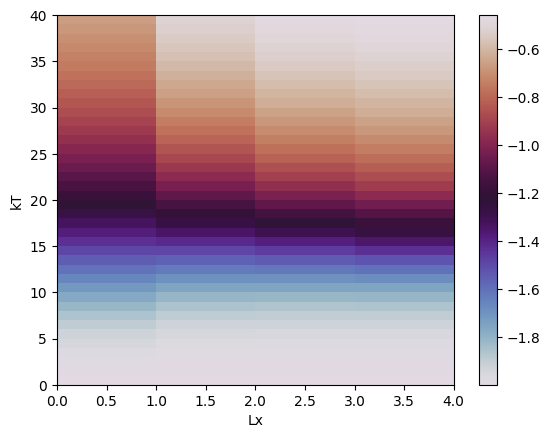

In [25]:
import matplotlib.pyplot as plt
data = np.load("matrix_of_mean_energies.txt.npy")
plt.pcolormesh(np.transpose(data), cmap='twilight')
plt.xlabel('Lx')
plt.ylabel('kT')
plt.colorbar()
plt.show()

In [12]:
@njit
def generator(n):
    for i in prange(n):
        yield i
for i in generator(400):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27